## Qualitative analysis

This is a notebook for qualitatively analysing nuScenes samples evaluated by the two safety-metrics. To gather the data used in this analysis, the main() function of the DetectionEval class of the modified nuscenes devkit provided should be run with the save_metrics_samples parameters set to a positive amount of samples. 

In [3]:
import numpy as np
import pandas as pd
import os
import json
import math
import random
from nuscenes import NuScenes
from PIL import Image
from visualization_helpers import * 



# Visualize for all detectors to compare
data_root ='/cluster/work/andronn/MasterThesis/MASTER/master_repo/Thesis-Evaluating-Safety-Oriented-Metrics-for-Object-Detectors/results/'
detectors = ['pointpillars-fpn/', 'regnet-regnetX_FPN/', 'ssn-REGNET/']
data_loc = [data_root+detector+'QUALITATIVE/'+'METRIC_SAMPLES/' for detector in detectors]
data_loc_m = [data_root+detector+'QUALITATIVE/'+'METRIC_SAMPLES_MODIFIED/' for detector in detectors]


In [ ]:
# Get sample tokens of selected samples    
with open(os.path.join(data_root, 'sample_tokens_selected.json'), 'r') as f:
    sample_tokens = json.load(f)['sample_tokens']



In [ ]:
# Choose an index in the sample list to analyse
for t in sample_tokens:
    print(t)
    
print("Length: ", len(sample_tokens))
idx = int(input("Input sample index to analyze: ")) 

from IPython.display import display

print("Sample {}:".format(sample_tokens[idx]))
display(Image.open(data_loc[0]+sample_tokens[idx]+'/SENSOR_ANN_VIZ.png'))

**Below we visualize the sample in question and the birds-eye Ground Truths (green) and Predictions (blue):**

In [ ]:

size=(1000,1000)
print("LIDAR predictions:")
display(visualize_crits(data_loc, detectors, sample_tokens[idx], 'N', size))
display(visualize_crits(data_loc, detectors, sample_tokens[idx], 'C', size))

print("LIDAR predictions (Modified):")

display(visualize_crits(data_loc_m, detectors, sample_tokens[idx], 'N', size))
display(visualize_crits(data_loc_m, detectors, sample_tokens[idx], 'C', size))


#display(visualize_crits(data_loc, detectors, sample_tokens[idx], 'C', size=(700,700)))
#display(visualize_crits(data_loc, detectors, sample_tokens[idx], 'D'))
#display(visualize_crits(data_loc, detectors, sample_tokens[idx], 'T'))
#display(visualize_crits(data_loc, detectors, sample_tokens[idx], 'R'))


In [ ]:
# Read tables into dataframes
# Headers every 2nd row in csvs:

dfs_pr = [pd.read_csv(path + sample_tokens[idx] + '/threshold_metrics.txt', 
                   delimiter=";", header=0) for path in data_loc]
dfs_pr_m = [pd.read_csv(path + sample_tokens[idx] + '/threshold_metrics.txt', 
                   delimiter=";", header=0) for path in data_loc_m]

keep_car_only = False

for i in range(len(dfs_pr)):
    # Remove duplicate headers
    dfs_pr[i] = dfs_pr[i][dfs_pr[i]['Class'].ne('Class')]
    dfs_pr_m[i] = dfs_pr_m[i][dfs_pr_m[i]['Class'].ne('Class')]
    if keep_car_only:
        dfs_pr[i] = dfs_pr[i][dfs_pr[i]['Class'].eq('car')]
        dfs_pr_m[i] = dfs_pr_m[i][dfs_pr_m[i]['Class'].eq('car')]
for i in range(len(dfs_pr)):
    p_crits = [row['Class']+': '+str(row['Prec_crit']) for index,row in dfs_pr[i].iterrows()]
    r_crits = [row['Class']+': '+str(row['Rec_crit']) for index,row in dfs_pr[i].iterrows()]
    
    print("\n\nDetector: {}".format(detectors[i]))
    with open(os.path.join(data_loc[i], sample_tokens[idx], 'pkl_results.json'), 'r') as f:
        print("PKL: {}\nPrecision_crits: {}\nRecall_crits:  {}".format(json.load(f)['full'][sample_tokens[idx]], 
                                                                       str(p_crits), 
                                                                       str(r_crits))) # print sample high-level metrics
    
for i in range(len(dfs_pr)):
    p_crits_m = [row['Class']+': '+str(row['Prec_crit']) for index,row in dfs_pr_m[i].iterrows()]
    r_crits_m = [row['Class']+': '+str(row['Rec_crit']) for index,row in dfs_pr_m[i].iterrows()] 
    
    print("\nDetector: {} - MODIFIED".format(detectors[i]))
    with open(os.path.join(data_loc_m[i], sample_tokens[idx], 'pkl_results.json'), 'r') as f:
        print("PKL: {}\nPrecision_crits: {}\nRecall_crits:  {}".format(json.load(f)['full'][sample_tokens[idx]], 
                                                                                  str(p_crits_m), 
                                                                                  str(r_crits_m))) # print sample high-level metrics
    
    


#visualize_table([d+sample_tokens[idx]+'/PR_summary.txt' for d in data_loc])
#visualize_table([d+sample_tokens[idx]+'/AP_summary.txt' for d in data_loc])

In [ ]:
print("Detailed metric data")
for i in range(len(dfs_pr)):
    print("Detector: {}".format(detectors[i]))
    display(dfs_pr[i])
    print("Detector: {} - MODIFIED".format(detectors[i]))
    display(dfs_pr_m[i])

#### Next cell is run independently, and is for visualizing larger quantities of metric data generated with the random_token_predictions parameter of main

In [170]:
#### data_root ='/cluster/work/andronn/MasterThesis/MASTER/master_repo/Thesis-Evaluating-Safety-Oriented-Metrics-for-Object-Detectors/results/'

import numpy as np
import pandas as pd
import os
import json
import math
import random
from nuscenes import NuScenes
from PIL import Image
from visualization_helpers import * 



# Visualize for all detectors to compare
data_root ='/cluster/work/andronn/MasterThesis/MASTER/master_repo/Thesis-Evaluating-Safety-Oriented-Metrics-for-Object-Detectors/results/'
detector = 'ssn-REGNET/'
#data_loc = [data_root+detector+'METRIC_SAMPLES_RANDOM/' for detector in detectors]
data_loc = data_root+detector+'FILTERED_METRIC_SAMPLES_RANDOM_FNs_40/'
keep_car_only = True

# Get sample tokens of selected samples    
with open(os.path.join(data_root, 'sample_tokens_random.json'), 'r') as f:
    sample_tokens = json.load(f)['sample_tokens']

pkls = []
precs = []
o_recs = []
o_precs = []
recs = []
f1=[]
o_f1=[]
for tok in sample_tokens:
    try:
        with open(os.path.join(data_loc, tok, 'pkl_results.json'), 'r') as f:
            val = json.load(f)['full'][tok]
            
            if math.isinf(val) or val <= 0.0:
                # hack to account for undefined values
                raise FileNotFoundError
    except FileNotFoundError as e:
        #print(str(e), ": deleting token {}".format(tok))
        continue
    
    try:
        dfs_pr = pd.read_csv(data_loc + tok + '/threshold_metrics.txt', 
                           delimiter=";", header=0)
        
    except FileNotFoundError as e:
        #print(str(e), ": deleting token {}".format(tok))
        continue
        

    # Remove duplicate headers
    dfs_pr = dfs_pr.drop_duplicates()
    dfs_pr = dfs_pr[dfs_pr['Class'].ne('Class')]
    dfs_pr = dfs_pr.dropna()
    
    if keep_car_only:
        dfs_pr = dfs_pr[(dfs_pr['Class'].eq('car'))]
        
        
        # Filter to ensure sufficient amount of class for sample to be evaluated
        dfs_pr = dfs_pr[((pd.to_numeric(dfs_pr['TPs']) + 
                                     pd.to_numeric(dfs_pr['FNs'])) <= 2)]
        
        #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FNs']) == 0]
        #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FPs']) == 0]  
        #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FNs_gt_crit']) == 1]
        #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FPs_pred_crit']) < 0.5]

    if len(dfs_pr)==0: continue
        
    # PRECISION AND RECALL
    p = pd.to_numeric(dfs_pr['Prec_crit'])[0]
    r = pd.to_numeric(dfs_pr['Rec_crit'])[0]
    o_p = pd.to_numeric(dfs_pr['Prec'])[0]
    o_r = pd.to_numeric(dfs_pr['Rec'])[0]
    precs.append(p)
    recs.append(r)
    o_precs.append(o_p)
    o_recs.append(o_r)
    if (np.isnan(2*(p*r)/(p+r))): # COMPUTE F1-score
        f1.append(0.0) 
    else:
        f1.append(2*(p*r)/(p+r))
    o_f1.append(2*(o_p*o_r)/(o_p+o_r))
    
    
    with open(os.path.join(data_loc, tok, 'pkl_results.json'), 'r') as f:
        val = json.load(f)['full'][tok]
        pkls.append(val)

        
def rolling_average(lst, num_avg):
    assert all(len(sublist) == len(lst[0]) for sublist in lst), "Sublists must have the same length"
    rolling_avgs = []
    for sublist in lst:
        rolling_sublist = []
        for i in range(0, len(sublist)-1, num_avg):
            rolling_sublist.append(np.mean(sublist[i:i+num_avg]))
        # handle the last element(s) separately
        last_elem_start_idx = len(sublist) - num_avg
        if last_elem_start_idx >= 0:
            last_rolling_avg = np.mean(sublist[last_elem_start_idx:])
            rolling_sublist.append(last_rolling_avg)
        rolling_avgs.append(rolling_sublist)
    return np.array(rolling_avgs)


precs = np.array(precs)
recs = np.array(recs)
pkls = np.array(pkls)
o_recs = np.array(o_recs)
o_precs = np.array(o_precs)
f1 = np.array(f1)
o_f1 = np.array(o_f1)

#pkls = np.array(pkls)
loger = lambda l: -np.log(l) 
lfunc = np.vectorize(loger)
pkls = lfunc(pkls)






/tmp/ipykernel_1641678/1077503179.py:83: RuntimeWarning: invalid value encountered in double_scalars
  if (np.isnan(2*(p*r)/(p+r))): # COMPUTE F1-score


Visualizing 37 samples
PearsonRResult(statistic=0.6468912050771946, pvalue=1.5168385400854006e-05)
SignificanceResult(statistic=0.5563392813993264, pvalue=0.0003495181712085382)
# original
PearsonRResult(statistic=0.2956856306599562, pvalue=0.07559730482557622)
SignificanceResult(statistic=0.5563392813993264, pvalue=0.0003495181712085382)


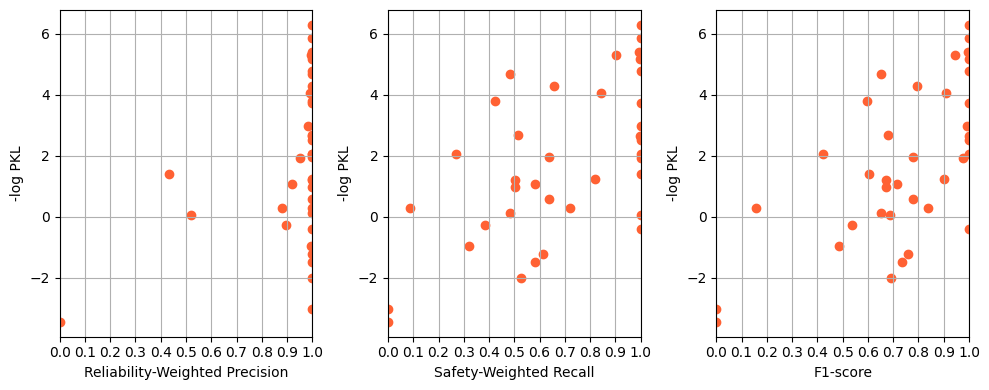

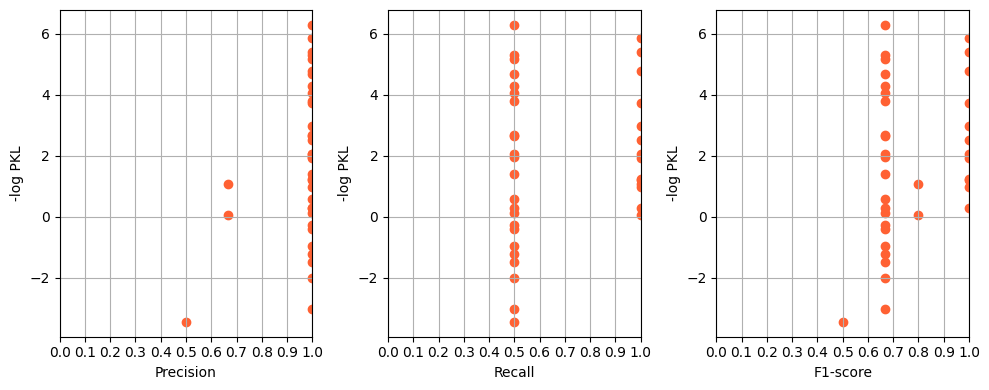

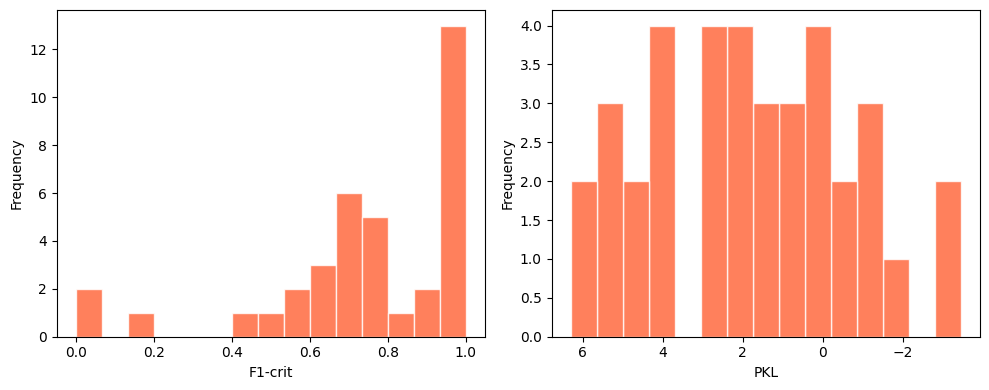

In [171]:

#precs_m, pkls_m, recs_m, maps_m = rolling_average([precs, pkls, recs, maps], 1)


print("Visualizing {} samples".format(len(precs)))
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

def plot(X, y, X_labels, y_label):
    #plt.xlim(np.min(x), np.max(x))
    #plt.ylim(np.min(y), np.max(y))
    fig, ax = plt.subplots(1, len(X),  figsize=(10, 4))
    for idx, x in enumerate(X): 
        if X_labels[idx]!="-log PKL":
            ax[idx].autoscale(False, axis="x")
            ax[idx].set_xticks(np.arange(0, 1.1, 0.1))
            
        ax[idx].set_ylabel(y_label)
        ax[idx].set_xlabel(X_labels[idx])
        ax[idx].grid()
        ax[idx].scatter(x, y, c='#ff6133')
    fig.tight_layout()
    plt.show()
#plot("mAP_crit", "-log PKL", maps, pkls, 1)     
#plt.xticks(np.linspace(0, 1, 10))

r = pearsonr(f1, pkls)
sr = spearmanr(f1, pkls)
o_r = pearsonr(o_f1, pkls)
o_sr = spearmanr(f1, pkls)
print(r)
print(sr)
print("# original")
print(o_r)
print(o_sr)
plot((precs,recs, f1), pkls, ("Reliability-Weighted Precision","Safety-Weighted Recall", "F1-score"), "-log PKL") 
plot((o_precs,o_recs, o_f1), pkls, ("Precision","Recall", "F1-score"), "-log PKL")



# Visualize Data: Histograms

fig, ax = plt.subplots(1, 2, figsize = (10,4))

# Plots #
    # Plot histogram
ax[0].hist(f1, density = False, bins = 15, color='#ff6133', alpha=0.8, edgecolor='#ffffff')
ax[1].hist(pkls, density = False, bins = 15, color='#ff6133', alpha=0.8, edgecolor='#ffffff')
ax[1].invert_xaxis()
# X #
ax[0].set_xlabel("F1-crit")
ax[1].set_xlabel("PKL")


# Relabel the axis as "Frequency"
ax[0].set_ylabel("Frequency")
ax[1].set_ylabel("Frequency")
# Overall #

fig.tight_layout()

plt.show()

#plot("Safety-Weighted Recall", "-log PKL", recs, pkls) 

#plot("mAP_crit", "-log PKL", maps, pkls, 1) 

In [ ]:
# FNs
detector = 'ssn-REGNET/'
falses = 6

#data_locs = [data_root+detector+'/FN_EX/'+'FN_EX_{}/'.format(i+1) for i in range(falses)]
data_locs = [data_root+detector+'/FP_EX/'+'FP_EX_{}/'.format(i+1) for i in range(falses)]
# Get sample tokens of selected samples    
with open(os.path.join(data_root, 'sample_tokens_random.json'), 'r') as f:
    sample_tokens = json.load(f)['sample_tokens'][:100]
    
p_avg = []
r_avg = []
pr_avg = []
o_r_avg = []
o_pr_avg = []

o_f1_avg = []
f1_avg = []

num_falses = range(falses)
it = 0
for data_loc in data_locs:
    pkls = []
    recs = []
    precs = []
    o_recs = []
    o_precs = []
    f1 = []
    o_f1 = []
    for tok in sample_tokens:
        try:
            with open(os.path.join(data_loc, tok, 'pkl_results.json'), 'r') as f:
                if math.isinf(json.load(f)['full'][tok]):
                    raise FileNotFoundError
        except FileNotFoundError as e:
            #print(str(e), ": deleting token {}".format(tok))
            continue

        try:
            dfs_pr = pd.read_csv(data_loc + tok + '/threshold_metrics.txt', 
                               delimiter=";", header=0)

        except FileNotFoundError as e:
            #print(str(e), ": deleting token {}".format(tok))
            continue


        # Remove duplicate headers
        dfs_pr = dfs_pr.drop_duplicates()
        dfs_pr = dfs_pr[dfs_pr['Class'].ne('Class')]
        dfs_pr = dfs_pr.dropna()

        dfs_pr = dfs_pr[(dfs_pr['Class'].eq('car'))]

          
        if len(dfs_pr)==0: continue
        p = pd.to_numeric(dfs_pr['Prec_crit'])[0]
        r = pd.to_numeric(dfs_pr['Rec_crit'])[0]
        o_p = pd.to_numeric(dfs_pr['Prec'])[0]
        o_r = pd.to_numeric(dfs_pr['Rec'])[0]
        
        
            
            
        precs.append(p)
        recs.append(r)
        o_precs.append(o_p)
        o_recs.append(o_r)
        if (np.isnan(2*(p*r)/(p+r))):
            f1.append(0.0)
        else:
            f1.append(2*(p*r)/(p+r))
        o_f1.append(2*(o_p*o_r)/(o_p+o_r))

        with open(os.path.join(data_loc, tok, 'pkl_results.json'), 'r') as f:
            pkl = json.load(f)['full'][tok]
            """if pkl <= 0.0:
                pkl = np.min(pkls)/2 # lowest recorded"""
            pkls.append(pkl)
            
    pkls = -np.array(pkls)
    recs = np.array(recs)
    precs = np.array(precs)
    o_recs = np.array(o_recs)
    o_precs = np.array(o_precs)
    o_f1 = np.array(o_f1)
    f1 = np.array(f1)
    print(len(pkls))
    """loger = lambda l: -np.log(l) 
    lfunc = np.vectorize(loger)
    pkls = lfunc(pkls)"""
    
    p_avg.append(np.average(pkls))
    r_avg.append(np.average(recs))
    pr_avg.append(np.average(precs))
    o_r_avg.append(np.average(o_recs))
    o_pr_avg.append(np.average(o_precs))
    o_f1_avg.append(np.average(o_f1))
    f1_avg.append(np.average(f1))
    it+=1
    
print(f1_avg, o_f1_avg, p_avg)


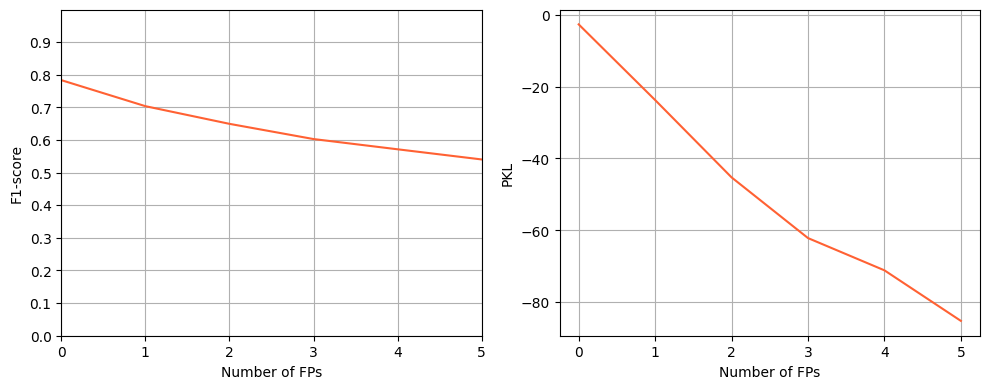

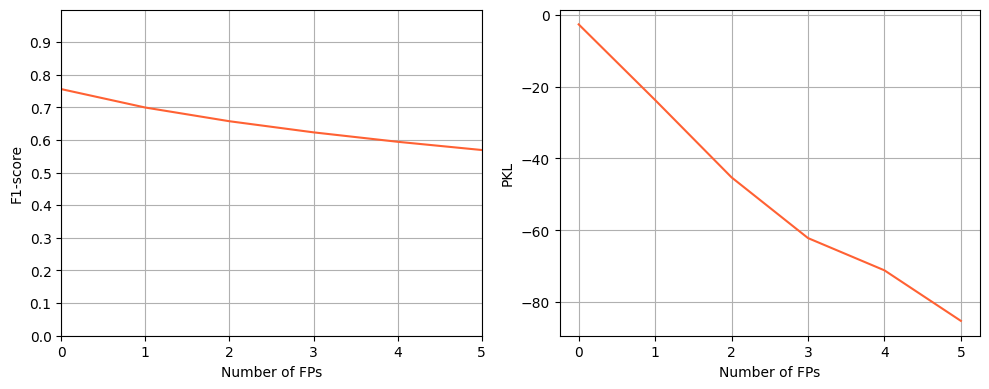

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_falses(x, Y, x_label, Y_labels):
    #plt.xlim(np.min(x), np.max(x))
    #plt.ylim(np.min(y), np.max(y))
    fig, ax = plt.subplots(1, len(Y),  figsize=(10, 4))
    for idx, y in enumerate(Y): 
        if Y_labels[idx]!="PKL":
            ax[idx].autoscale(False)
            ax[idx].set_yticks(np.arange(0,1, 0.1))
        ax[idx].set_xticks(x)
        ax[idx].set_xlabel(x_label)
        ax[idx].set_ylabel(Y_labels[idx])
        ax[idx].grid()
        ax[idx].plot(x, y, c='#ff6133')
    fig.tight_layout()
    plt.show()
    
    
    
#plot_falses(num_falses, (r_avg, p_avg), "Number of FNs", ("Safety-Weighted Recall", "PKL"))
#plot_falses(num_falses, (r_avg, pr_avg, p_avg), "Number of FPs", ("Safety-Weighted Recall", "Reliability-Weighted Precision", "PKL"))
#plot_falses(num_falses, (o_r_avg, o_pr_avg, p_avg), "Number of FPs", ("Safety-Weighted Recall", "Reliability-Weighted Precision", "PKL"))

plot_falses(num_falses, (f1_avg, p_avg), "Number of FPs", ("F1-score", "PKL"))
#plot_falses(num_falses, (o_f1_avg, p_avg), "Number of FPs", ("F1-score", "PKL"))

                                                                  
                                                                  

## Plotting differences
Below is an experiment to visualize the changes in PKL and OCM respectively resulting from introducing FPs or FNs to the samples

In [28]:
import numpy as np
import pandas as pd
import os
import json
import math
import random
from nuscenes import NuScenes
from PIL import Image
from visualization_helpers import * 



# Visualize for all detectors to compare
data_root ='/cluster/work/andronn/MasterThesis/MASTER/master_repo/Thesis-Evaluating-Safety-Oriented-Metrics-for-Object-Detectors/results/'
detector = 'ssn-REGNET/'
#data_loc = [data_root+detector+'METRIC_SAMPLES_RANDOM/' for detector in detectors]
data_loc = [data_root+detector+'FILTERED_METRIC_SAMPLES_RANDOM_RAW_40/', 
            data_root+detector+'FILTERED_METRIC_SAMPLES_RANDOM_FPs_40/']


keep_car_only = True

# Get sample tokens of selected samples    
with open(os.path.join(data_root, 'sample_tokens_random.json'), 'r') as f:
    sample_tokens = json.load(f)['sample_tokens']


pkls = [[], []]
precs = [[], []]
recs = [[], []]
dfs_pr = []
sample_tokens_m = []

for tok in sample_tokens:
    imcomparable = False
    for i in range(0,2):
        try:
            with open(os.path.join(data_loc[i], tok, 'pkl_results.json'), 'r') as f:
                val = json.load(f)['full'][tok]

                if math.isinf(val) or val <= 0.0:
                    raise FileNotFoundError
        except FileNotFoundError as e:
            #print(str(e), ": deleting token {}".format(tok))
            imcomparable = True

        try:
            dfs_pr = pd.read_csv(data_loc[i] + tok + '/threshold_metrics.txt', 
                               delimiter=";", header=0)

        except FileNotFoundError as e:
            #print(str(e), ": deleting token {}".format(tok))
            imcomparable = True
        

        # Remove duplicate headers
        dfs_pr = dfs_pr.drop_duplicates()
        dfs_pr = dfs_pr[dfs_pr['Class'].ne('Class')]
        dfs_pr = dfs_pr.dropna()

        if keep_car_only:
            dfs_pr = dfs_pr[(dfs_pr['Class'].eq('car'))]



            # Filter to ensure sufficient amount of class for sample to be evaluated
            dfs_pr = dfs_pr[(pd.to_numeric(pd.to_numeric(dfs_pr['TPs']) + 
                                           pd.to_numeric(dfs_pr['FNs'])) <= 10)]
            #dfs_pr = dfs_pr[((pd.to_numeric(dfs_pr['TPs']) + 
            #                          pd.to_numeric(dfs_pr['FNs'])) <= 8)]
            #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FPs']) == 0]
            
        if len(dfs_pr)==0:
            imcomparable = True
    if not imcomparable:
        sample_tokens_m.append(tok)
        

for tok in sample_tokens_m:
    for i in range(0,2):
        try:
            dfs_pr = pd.read_csv(data_loc[i] + tok + '/threshold_metrics.txt', 
                               delimiter=";", header=0)

        except FileNotFoundError as e:
            #print(str(e), ": deleting token {}".format(tok))
            continue
        
        # Remove duplicate headers
        dfs_pr = dfs_pr.drop_duplicates()
        dfs_pr = dfs_pr[dfs_pr['Class'].ne('Class')]
        dfs_pr = dfs_pr.dropna()

        if keep_car_only:
            dfs_pr = dfs_pr[(dfs_pr['Class'].eq('car'))]



            # Filter to ensure sufficient amount of class for sample to be evaluated
            dfs_pr = dfs_pr[(pd.to_numeric(pd.to_numeric(dfs_pr['TPs']) + 
                                           pd.to_numeric(dfs_pr['FNs'])) <= 10)]
            
            #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FPs']) == 0]
            #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FNs']) > 0]  
            #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FNs_gt_crit']) == 1]
            #dfs_pr = dfs_pr[pd.to_numeric(dfs_pr['FPs_pred_crit']) < 0.5]
        #print(dfs_pr_m[0]['Prec_crit'])
        precs[i].append(pd.to_numeric(dfs_pr['Prec_crit'])[0])
        recs[i].append(pd.to_numeric(dfs_pr['Rec_crit'])[0])


        with open(os.path.join(data_loc[i], tok, 'pkl_results.json'), 'r') as f:
            val = json.load(f)['full'][tok]
            pkls[i].append(val)
        
for i in range(0,2):      
    precs[i] = np.array(precs[i])
    recs[i] = np.array(recs[i])
    pkls[i] = np.array(pkls[i])
    #pkls = np.array(pkls)
    loger = lambda l: -np.log(l) 
    lfunc = np.vectorize(loger)
    pkls[i] = lfunc(pkls[i])
    



    

In [29]:
d_pkls = [] # Holds the differences between metric values before/after introduction of misdetections for same samples
d_precs = []
d_recs = []

for i in range(0, len(precs[0])):
    d_precs.append(precs[1][i]-precs[0][i])
    d_recs.append(recs[1][i]-recs[0][i])
    d_pkls.append(pkls[1][i]-pkls[0][i])


Visualizing 561 samples


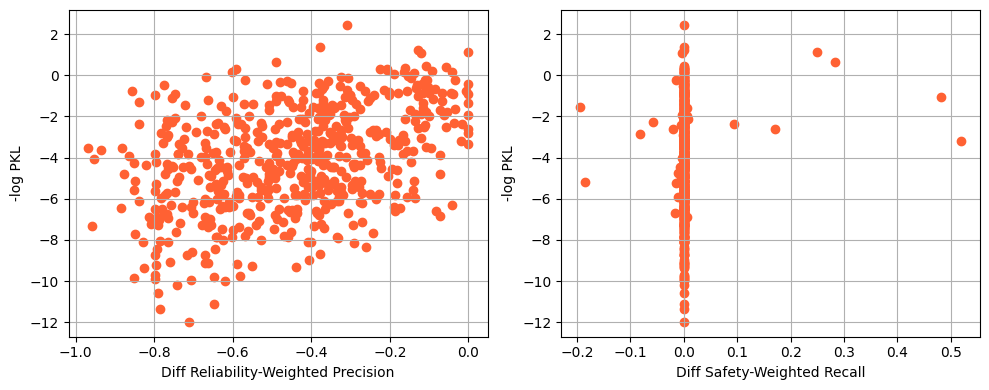

In [30]:
print("Visualizing {} samples".format(len(precs[0])))
import matplotlib.pyplot as plt

def plot(X, y, X_labels, y_label):
    #plt.xlim(np.min(x), np.max(x))
    #plt.ylim(np.min(y), np.max(y))
    fig, ax = plt.subplots(1, len(X),  figsize=(10, 4))
    for idx, x in enumerate(X): 
        #if X_labels[idx]!="-log PKL":
            #ax[idx].autoscale(False, axis="x")
            #ax[idx].set_xticks(np.arange(0, 1.1, 0.1))
            
        ax[idx].set_ylabel(y_label)
        ax[idx].set_xlabel(X_labels[idx])
        ax[idx].grid()
        ax[idx].scatter(x, y, c='#ff6133')
    fig.tight_layout()
    plt.show()
#plot("mAP_crit", "-log PKL", maps, pkls, 1)     
#plt.xticks(np.linspace(0, 1, 10))
plot((d_precs,d_recs), d_pkls, ("Diff Reliability-Weighted Precision","Diff Safety-Weighted Recall"), "-log PKL") 